In [20]:
import numpy as np
import pandas as pd
from numpy import linalg as nplin
import volpriceinference as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool

In [21]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [22]:
logging.basicConfig(filename='convergence.tmp.log', level=logging.INFO)
logging.captureWarnings(True)

## Setup the True Parameters /  Simulation Parameters

In [23]:
true_params = {'equity_price': 0.50, 
               'vol_price': -7,
               'phi':-.2,
               'scale': .1,
               'delta': 1.11,
               'rho': .6,
              }
time_dim = 3000
sim_dim = 1000

## Setup the linking functions.

In [24]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.gamma(rho=true_params['rho'], scale=true_params['scale'], delta=true_params['delta'], 
                       phi=true_params['phi'], pi=true_params['vol_price'], theta=true_params['equity_price']),
     'beta':vl.beta(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                    pi=true_params['vol_price'], theta=true_params['equity_price']),
     'psi':vl.psi(true_params['rho'], true_params['scale'], true_params['phi'], 
                  theta=true_params['equity_price']), 
     'phi_squared': true_params['phi']**2})

## We start by examining the distributions of simulated data

In [25]:
vl.__version__

'0.0.03-py36_8'

In [26]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

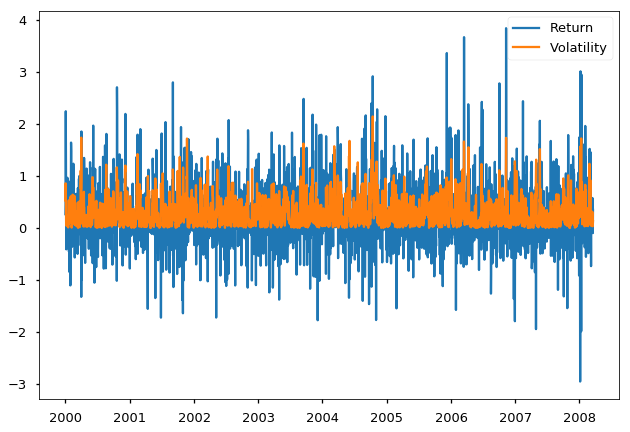

In [27]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return')
ax1.plot(data.vol, label='Volatility')
ax1.legend()


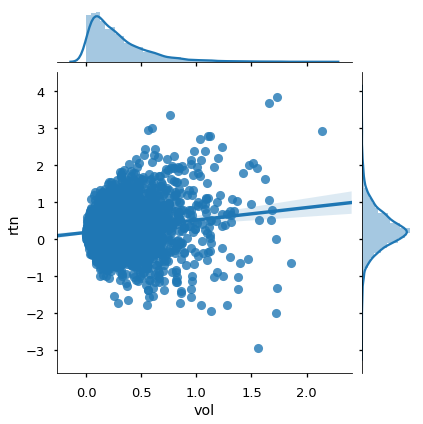

In [28]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [29]:
data.describe()

,vol,rtn
count,3000.000000,3000.000000
mean,0.292445,0.278113
std,0.270722,0.584337
min,0.000184,-2.955314
25%,0.101028,-0.053719
50%,0.217497,0.233304
75%,0.404714,0.581471
max,2.144154,3.841184


## The Asymptotic Distributions in the Strongly Identified Case

In [30]:
def gen_data(x):
    return vl.simulate_data(time_dim=time_dim, **true_params) 

In [31]:
# with Pool(8) as pool:
data_arr = list(map_unordered(gen_data, tqdm.tnrange(sim_dim)))

NameError: name 'map_unordered' is not defined

In [ ]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(vl.estimate_params, data_arr), total=len(data_arr)))

In [ ]:
delta_fig, delta_ax = mpl.pyplot.subplots()
sns.distplot([(est['delta'] - true_params['delta']) / np.sqrt(cov.loc['delta','delta']) 
              for est, cov in est_arr], ax=delta_ax)
delta_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
delta_ax.set_xlabel('delta')

In [ ]:
scale_fig, scale_ax = mpl.pyplot.subplots()
sns.distplot([(est['scale'] - true_params['scale']) / np.sqrt(cov.loc['scale', 'scale']) 
              for est, cov in est_arr], ax=scale_ax)
scale_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
scale_ax.set_xlabel('scale')

In [ ]:
rho_fig, rho_ax = mpl.pyplot.subplots()
sns.distplot([(est['rho'] - true_params['rho']) / np.sqrt(cov.loc['rho', 'rho']) 
              for est, cov in est_arr], ax=rho_ax)
rho_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
rho_ax.set_xlabel('rho')

In [ ]:
equity_price_fix, equity_price_ax = mpl.pyplot.subplots()
sns.distplot([(est['equity_price'] - true_params['equity_price']) / 
              np.sqrt(cov.loc['equity_price', 'equity_price']) for est, cov in est_arr], ax=equity_price_ax)
equity_price_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
equity_price_ax.set_xlabel('equity price')

In [ ]:
vol_price_fix, vol_price_ax = mpl.pyplot.subplots()
sns.distplot([(est['vol_price'] - true_params['vol_price']) / 
              np.sqrt(cov.loc['vol_price', 'vol_price']) for est, cov in est_arr], ax=vol_price_ax)
vol_price_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
vol_price_ax.set_xlabel('vol_price')

In [ ]:
phi_fig, phi_ax = mpl.pyplot.subplots()
sns.distplot([(est['phi'] - true_params['phi']) / np.sqrt(cov.loc['phi', 'phi'])
              for est, cov in est_arr], ax=phi_ax)
phi_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
phi_ax.set_xlabel('phi')
phi_ax.set_xlim([-10,10])